# TDVP numerical test \#1

The goal is to use the TDVP to simulate the time evolution of a simple Hamiltonian, when state space is restricted to some manifold Furthermore a goal is to compare this method with directly solving the SE and projecting to the manifold.

The first example will be $\mathcal{M}= S^2$ and $H=\sigma_x$ to generate an X-rotation of a 1-qubit system. Note that the Bloch-sphere is a restriction of the entire 2-dim $\mathcal{H}$ onto a sphere. 

In [1]:
from math import * 
import numpy as np
import scipy as sp
import mayavi
import matplotlib.pyplot as plt

import qutip as qt

from itertools import combinations
from typing import Iterable, Callable

In [2]:
H=qt.sigmax()
def psi(pars:Iterable[float])->qt.qobj.Qobj:
    
    return np.cos(pars[0]/2)*qt.basis(2,0)+np.exp(1j*pars[1])*np.sin(pars[0]/2)*qt.basis(2,1)

In [3]:
def finitediff(func:Callable[[Iterable[float]],qt.Qobj],epsilon:float=10e-10)->Callable[[Iterable[float]],qt.Qobj]:
    def dfunc(params):
        difference = list()
        for i in range(2):
            p_params = list(params)
            p_params[i]+=epsilon
            difference.append((func(p_params)-func(params))/epsilon)
        return difference
    return dfunc
    

In [4]:
df = finitediff(psi)

In [5]:
df((1,1))

[Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[-0.23971281+0.j        ]
  [ 0.23707997+0.36923015j]],
 Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
 Qobj data =
 [[ 0.        +0.j        ]
  [-0.40342274+0.25903474j]]]

In [6]:
def G(psi:Callable[[Iterable[float]],qt.Qobj],pars:Iterable[float])->np.matrix:
    dpsi = finitediff(psi)
    return np.matrix([[
        (dpsi(pars)[j].dag()*(H*dpsi(pars)[k])).full()[0][0]
        for j in range(2)]for k in range(2)])


In [7]:
def grad(psi:Callable[[Iterable[float]],qt.Qobj], pars:Iterable[float],H:qt.Qobj=qt.sigmax())->np.matrix:
    dpsi = finitediff(psi)
    return np.matrix([
        (dpsi(pars)[k].dag()*(H*psi(pars))).full()[0][0]
        for k in range(2)])

In [8]:
def G_man(psi,pars: Iterable[float]) -> np.matrix:
    th,ph = pars
    return np.matrix([[1/4*(np.sin(th/2)**2 + np.exp(1j*2*ph)*np.cos(th/2)**2), (1j*np.exp(1j*ph)-1)*np.sin(th)],
                      [(1j*np.exp(1j*ph)-1)*np.sin(th), np.cos(th/2)**2 - np.exp(1j*2*ph)*np.sin(th/2)**2]])


In [9]:
def grad_man(psi,pars:Iterable[float],H:qt.Qobj=qt.sigmax()):
    # for sigmax()
    th, ph = pars
    return np.matrix([1/2*np.exp(-1j*ph)*(np.cos(th/2)**2 - 1j*np.exp(1j*ph)*np.sin(th/2)*np.cos(th/2)),
    1/2*(1+1j)*np.exp(1j*ph)*np.sin(th)])

In [10]:
grad(psi,(0,0))

matrix([[0.5+0.j, 0. +0.j]])

In [11]:
grad_man((0,0))

TypeError: grad_man() missing 1 required positional argument: 'pars'

In [ ]:
grad(psi,(0,0))

matrix([[0.+0.j, 0.+0.j]])

In [ ]:
G(psi,[0,0])

matrix([[0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]])

In [ ]:
def linear_evo(psi:Callable[[Iterable[float]],qt.Qobj],par_0:Iterable[float],H:qt.Qobj=qt.sigmax(),stepsize:float=.5,steps:int=1000):
    par_list = [par_0]
    for t in range(steps):
        par = par_list[-1]
        new_par = (np.matrix([par]) - 1j*stepsize*np.linalg.inv(G(psi,par))*grad(psi,par,H).T).tolist()[0]
        # new_par=np.real_if_close(new_par,tol=10000)
        # assert np.isrealobj(new_par), f"imaginary part to large: {new_par}"
        new_par=np.absolute(new_par)
        par_list.append((new_par[0], new_par[1]))
        
    return par_list
    

In [ ]:
pts = linear_evo(psi,(0.1,0.1),H=qt.sigmay(),steps=1000,stepsize=.01)

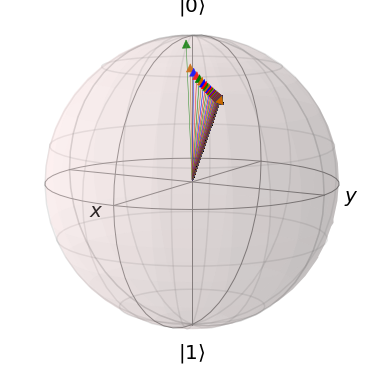

In [ ]:
b = qt.Bloch()
b.add_states([psi(pt) for pt in pts],kind="vector")
b.view=[-60,10]
b.vector_width=.5
b.show()

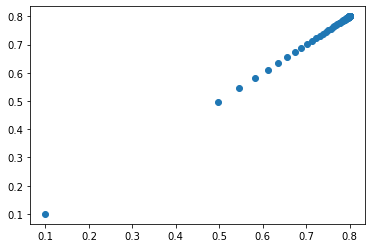

In [ ]:
x = [x for (x,y) in pts]
y = [y for (x,y) in pts]
plt.scatter(x,y)

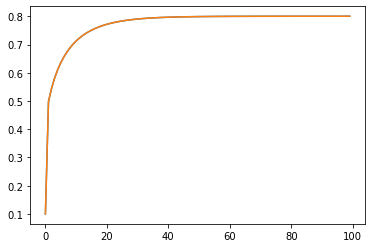

In [ ]:
plt.plot(pts[:100])

In [ ]:
psi(pts[-1]).norm()

1.0

In [ ]:
bb = qt.Bloch()
bb.add_states(psi(pts[-1]))

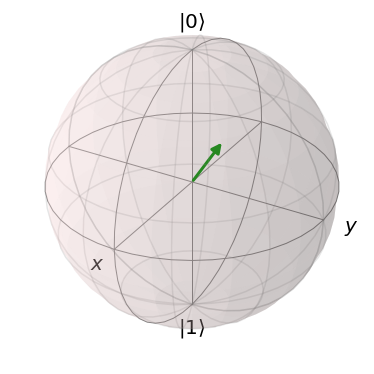

In [ ]:
bb.show()

In [ ]:
np.pi/4

0.7853981633974483

In [ ]:
tlist = np.linspace(0,2,40)

In [ ]:
result = qt.sesolve(qt.sigmay(),psi((0.1,0.1)),tlist=tlist)

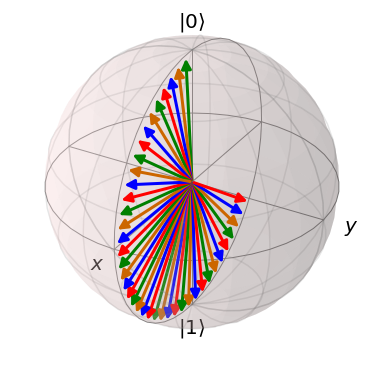

In [ ]:
bbb = qt.Bloch()
bbb.add_states(result.states)
bbb.show()